In [1]:
from torch.utils.data import Dataset, DataLoader
import kagglehub
import torchvision.transforms as T
from torchvision.utils import make_grid
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
from tqdm import tqdm

In [2]:
to_tensor = T.ToTensor()

def load_image(path):
    return to_tensor(Image.open(path))


def show_images(imgs):
    # imgs is a tensor of shape: B x C x H x W
    grid = make_grid(imgs, nrow=4, padding=10, pad_value=1)
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis("off")
    plt.gcf().set_figwidth(8)
    plt.show()

In [3]:
class Monet(Dataset):
    def __init__(self):
        self.data_path = kagglehub.dataset_download(
            "dimitreoliveira/monet-paintings-jpg-berkeley")
        self.img_names = os.listdir(self.data_path)

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, index):
        return load_image(os.path.join(self.data_path, self.img_names[index]))

In [12]:
from torchvision.datasets import CIFAR10
from torchvision import transforms

monet = Monet()
cifar = CIFAR10(root="./cifar10", train=True,
                download=True, transform=to_tensor)

batch_size = 64
monet_loader = DataLoader(monet, batch_size=batch_size, shuffle=True)
cifar_loader = DataLoader(cifar, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


In [39]:
cifar[0][0].max()

tensor(1.)

Define models

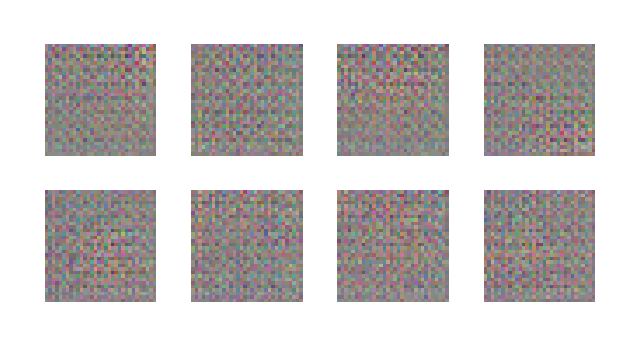

In [43]:
from torch import nn

class GeneratorResidualBlock(nn.Module):
    def __init__(self, n_channels):
        super().__init__()
        self.layers = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(n_channels, n_channels, kernel_size=3),
            nn.InstanceNorm2d(n_channels),
            nn.ReLU(),
            nn.ReflectionPad2d(1),
            nn.Conv2d(n_channels, n_channels, kernel_size=3),
            nn.InstanceNorm2d(n_channels),
            nn.ReLU(),
        )
    
    def forward(self, x):
        return x + self.layers(x)
    

class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        layers = []

        # initial convolution
        layers += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(3, 64, kernel_size=7),
            nn.InstanceNorm2d(64),
            nn.ReLU(),
        ]
        # downsample
        layers += [
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 128, kernel_size=3, stride=2),
            nn.InstanceNorm2d(128),
            nn.ReLU(),
            nn.ReflectionPad2d(1),
            nn.Conv2d(128, 256, kernel_size=3, stride=2),
            nn.InstanceNorm2d(256),
            nn.ReLU(),
        ]
        # residual blocks
        for _ in range(6):
            layers.append(GeneratorResidualBlock(256))
        # upsample
        layers += [
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(),
        ]
        # final convolution
        layers += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, 3, kernel_size=7),
            nn.Sigmoid()
        ]

        # put all the layers together
        self.layers = nn.Sequential(*layers)

    
    def forward(self, x):
        return self.layers(x)


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        pass

g = Generator()
imgs, labels = next(iter(cifar_loader))
show_images(g(imgs[:8]))
